In [1]:
import numpy as np

In [2]:
import os.path as op

import nibabel as nib
import pandas as pd

from AFQ import api
import AFQ.data as afd

/Users/arokem/miniconda3/envs/life-support/lib/python3.8/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
afd.organize_stanford_data()

INFO:AFQ.data:fetching Stanford HARDI data
INFO:dipy.data.fetcher:Dataset is already in place. If you want to fetch it again please first remove the folder /Users/arokem/.dipy/stanford_hardi 
INFO:AFQ.data:Dataset is already in place. If you want to fetch it again please first remove the folder /Users/arokem/AFQ_data/stanford_hardi/derivatives


In [4]:
base_dir = op.join(op.expanduser('~'), 'AFQ_data', 'stanford_hardi')

In [5]:
myafq = api.AFQ(bids_path=op.join(afd.afq_home,
                                  'stanford_hardi'),
                dmriprep='vistasoft',
                tracking_params=dict(n_seeds=2),
                segmentation_params = dict(return_idx = True))

INFO:dipy.data.fetcher:Dataset is already in place. If you want to fetch it again please first remove the folder /Users/arokem/AFQ_data/templates 
INFO:dipy.data.fetcher:Dataset is already in place. If you want to fetch it again please first remove the folder /Users/arokem/AFQ_data/callosum_templates 
/Users/arokem/miniconda3/envs/life-support/lib/python3.8/site-packages/bids/layout/models.py:98: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  warnings.warn("The 'extension' entity currently excludes the leading dot ('.'). "


In [41]:
import matplotlib.pyplot as plt

In [42]:
myafq.export_bundles()

INFO:AFQ.api:Saving /Users/arokem/AFQ_data/stanford_hardi/derivatives/afq/sub-01/ses-01/clean_bundles/sub-01_ses-01_dwi_space-RASMM_model-DTI_desc-det-AFQ-ATR_R_tractography.trk
INFO:AFQ.api:Saving /Users/arokem/AFQ_data/stanford_hardi/derivatives/afq/sub-01/ses-01/clean_bundles/sub-01_ses-01_dwi_space-RASMM_model-DTI_desc-det-AFQ-ATR_L_tractography.trk
INFO:AFQ.api:Saving /Users/arokem/AFQ_data/stanford_hardi/derivatives/afq/sub-01/ses-01/clean_bundles/sub-01_ses-01_dwi_space-RASMM_model-DTI_desc-det-AFQ-CGC_R_tractography.trk
INFO:AFQ.api:Saving /Users/arokem/AFQ_data/stanford_hardi/derivatives/afq/sub-01/ses-01/clean_bundles/sub-01_ses-01_dwi_space-RASMM_model-DTI_desc-det-AFQ-CGC_L_tractography.trk
INFO:AFQ.api:Saving /Users/arokem/AFQ_data/stanford_hardi/derivatives/afq/sub-01/ses-01/clean_bundles/sub-01_ses-01_dwi_space-RASMM_model-DTI_desc-det-AFQ-CST_R_tractography.trk
INFO:AFQ.api:Saving /Users/arokem/AFQ_data/stanford_hardi/derivatives/afq/sub-01/ses-01/clean_bundles/sub-01_s

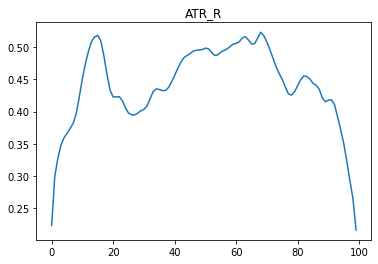

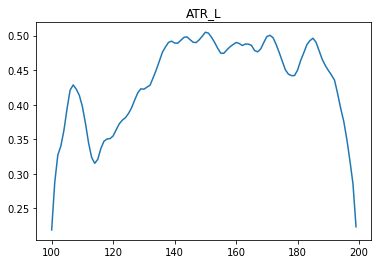

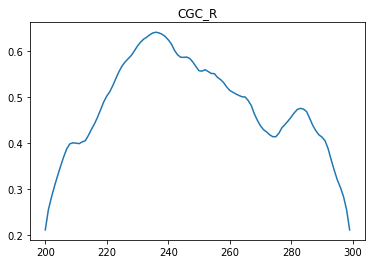

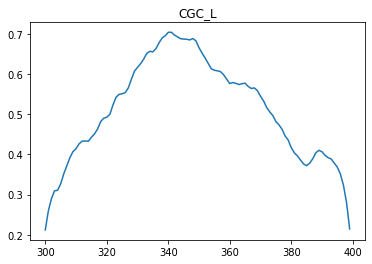

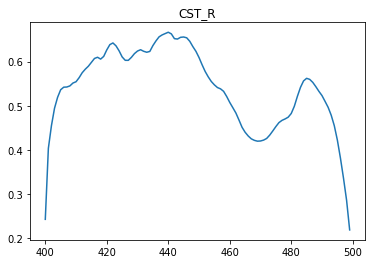

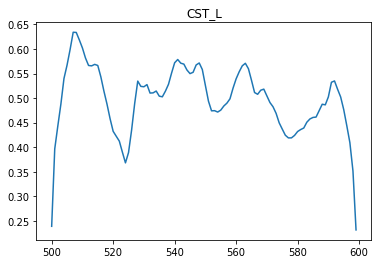

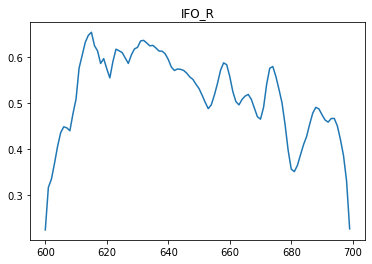

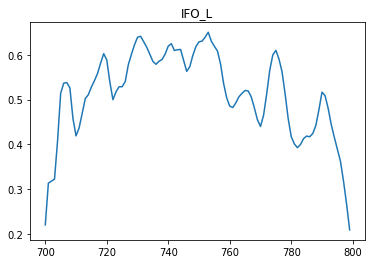

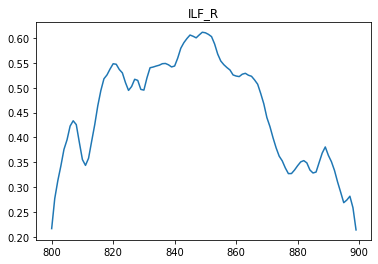

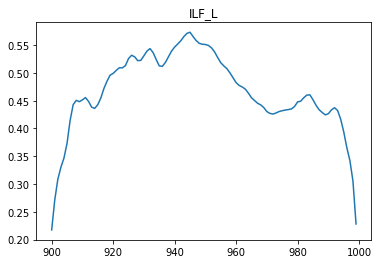

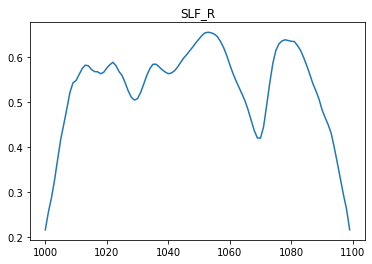

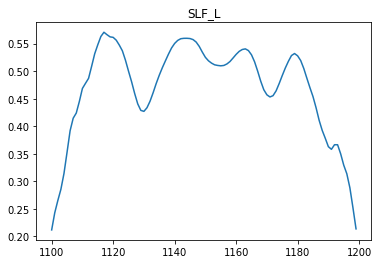

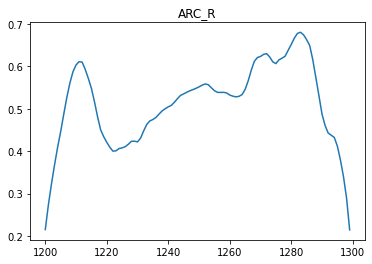

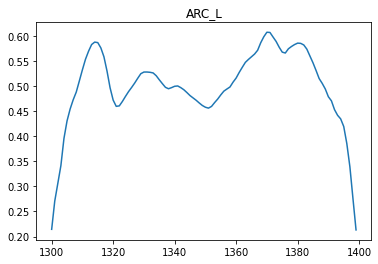

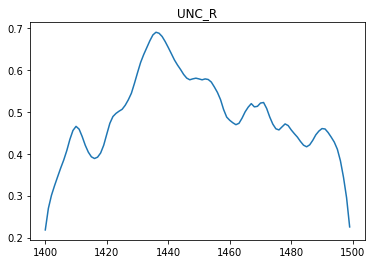

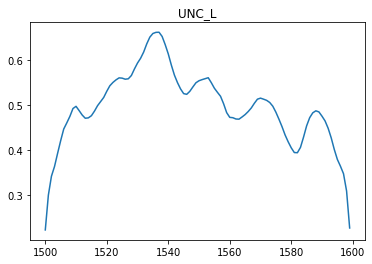

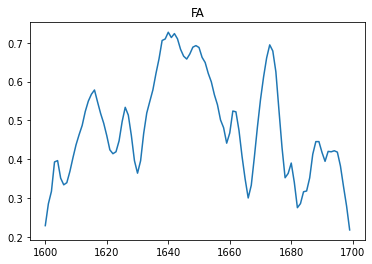

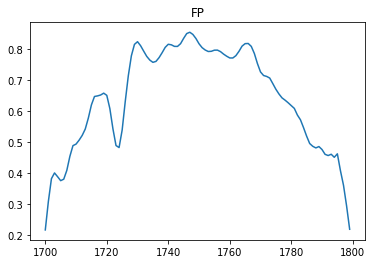

In [43]:
df = pd.read_csv(myafq.tract_profiles[0])
for bundle in df['tractID'].unique():
    fig, ax = plt.subplots(1)
    ax.plot(df[(df['tractID'] == bundle)]['dti_fa'])
    ax.set_title(bundle)

In [10]:
import dipy.tracking.life as life

In [11]:
gtab = myafq.gtab[0]

In [12]:
data = myafq.dwi_img[0].get_fdata()

In [13]:
fiber_model = life.FiberModel(gtab)

In [14]:
from dipy.io.streamline import load_trk

In [15]:
sft = load_trk(
    "/Users/arokem/AFQ_data/stanford_hardi/derivatives/afq/sub-01/ses-01/sub-01_ses-01_dwi_space-RASMM_model-DTI_desc-det-AFQ-clean_tractography.trk",
    "same")
sft.to_vox()

In [16]:
sft.to_vox()

In [17]:
fiber_fit_all = fiber_model.fit(data, sft.streamlines, np.eye(4))

In [18]:
bundle = "ARC_L"

In [19]:
uid = myafq.bundle_dict[bundle]['uid']

In [20]:
uid

14

In [21]:
bundle_idx = sft.data_per_streamline['bundle'] == uid

In [22]:
bundle_sft = load_trk(
    "/Users/arokem/AFQ_data/stanford_hardi/derivatives/afq/sub-01/ses-01/clean_bundles/sub-01_ses-01_dwi_space-RASMM_model-DTI_desc-det-AFQ-%s_tractography.trk"%bundle,
    "same")
bundle_sft.to_vox()

In [23]:
fiber_fit_bundle = fiber_model.fit(data, bundle_sft.streamlines, np.eye(4))

In [24]:
bundle_idx = bundle_idx.squeeze()

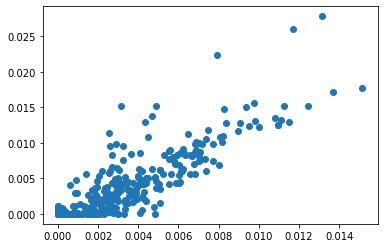

In [25]:
plt.scatter(fiber_fit_all.beta[bundle_idx], fiber_fit_bundle.beta)

In [26]:
pred = fiber_fit_bundle.predict()

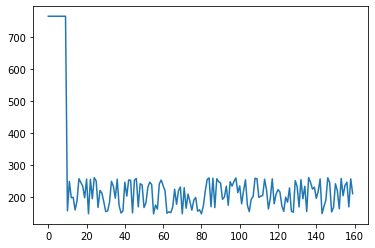

In [27]:
plt.plot(pred[0])

In [28]:
vol_pred = np.zeros(data.shape)
vol_pred[fiber_fit_bundle.vox_coords[:, 0],
         fiber_fit_bundle.vox_coords[:, 1],
         fiber_fit_bundle.vox_coords[:, 2]] = pred
vol_pred[np.isnan(vol_pred)] = 0

mask = np.zeros(data.shape[:3])
mask[fiber_fit_bundle.vox_coords[:, 0],
     fiber_fit_bundle.vox_coords[:, 1],
     fiber_fit_bundle.vox_coords[:, 2]] = 1

In [29]:
from dipy.reconst import dti

In [30]:
np.any(np.isnan(pred))

False

In [31]:
np.any(np.isnan(vol_pred))

False

In [32]:
dt_model = dti.TensorModel(gtab)

In [33]:
dt_fit = dt_model.fit(vol_pred, mask=mask)

(array([704., 315., 223., 162., 114., 119.,  81.,  61.,  67.,  27.]),
 array([2.41096763e-06, 8.71655183e-02, 1.74328626e-01, 2.61491733e-01,
        3.48654840e-01, 4.35817948e-01, 5.22981055e-01, 6.10144162e-01,
        6.97307269e-01, 7.84470377e-01, 8.71633484e-01]),
 <BarContainer object of 10 artists>)

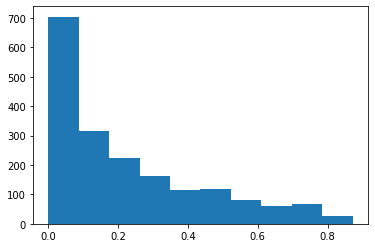

In [48]:
plt.hist(dt_fit.fa[dt_fit.fa > 0])

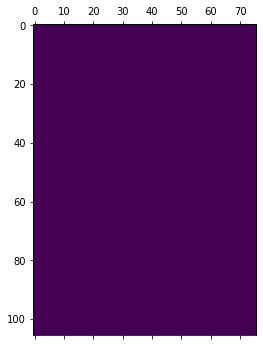

In [46]:
plt.matshow(dt_fit.fa[50])

In [35]:
from dipy.stats.analysis import afq_profile

In [36]:
bundle_sft.to_vox()

In [37]:
profile = afq_profile(dt_fit.fa, bundle_sft.streamlines, np.eye(4))

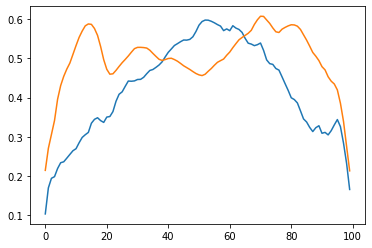

In [49]:
plt.plot(np.arange(100), profile)
plt.plot(np.arange(100), df[(df['tractID'] == "ARC_L")]['dti_fa'])

In [ ]:
# Fiber density
# Normalization 
# Find in every cross-section, find the largest weight or "purest signal". 

# Validation? qT1/PD correlation

# Downsample and see whether I can recover high-res signal

